[Cours](https://learn.deeplearning.ai/langchain/lesson/4/chains)

Dans ce cours on a recours aux "chaînes" qui permet de combiner un ou plusieurs prompts avec la configuration du LLM

Date : 09-12-23

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [3]:
llm_model = 'gpt-3.5-turbo'

In [4]:
import pandas as pd
df = pd.read_csv('data/review.csv')

In [5]:
df.head()

,Unnamed: 0,Product,Review
0,0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,2,Luxury Air Mattress,This mattress had a small hole in the top of i...
3,3,Pillows Insert,This is the best throw pillow fillers on Amazo...
4,4,Milk Frother Handheld,I loved this product. But they only seem to la...


## LLMChain
Combinaison d'un prompt et de la configuration du LLM

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [7]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

In [8]:
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

In [9]:
chain = LLMChain(llm=llm, prompt=prompt)

In [10]:
product = "Queen Size Sheet Set"
chain.run(product)

"Some possible names for a company that makes Queen Size Sheet Sets could be:\n\n1. Royal Linens\n2. Queen's Choice Bedding\n3. Majestic Sheets\n4. Regal Dreams Beddings\n5. Crown Comfort Linens\n6. Noble Nest Beddings\n7. Luxe Queen Sheets\n8. Supreme Sleep Linens\n9. Elite Beddings\n10. Sovereign Slumber Linens"

## SimpleSequentialChain

Avec cette librairie, il y a continuité / cheminement des prompts proposés (une entrée / une sortie)

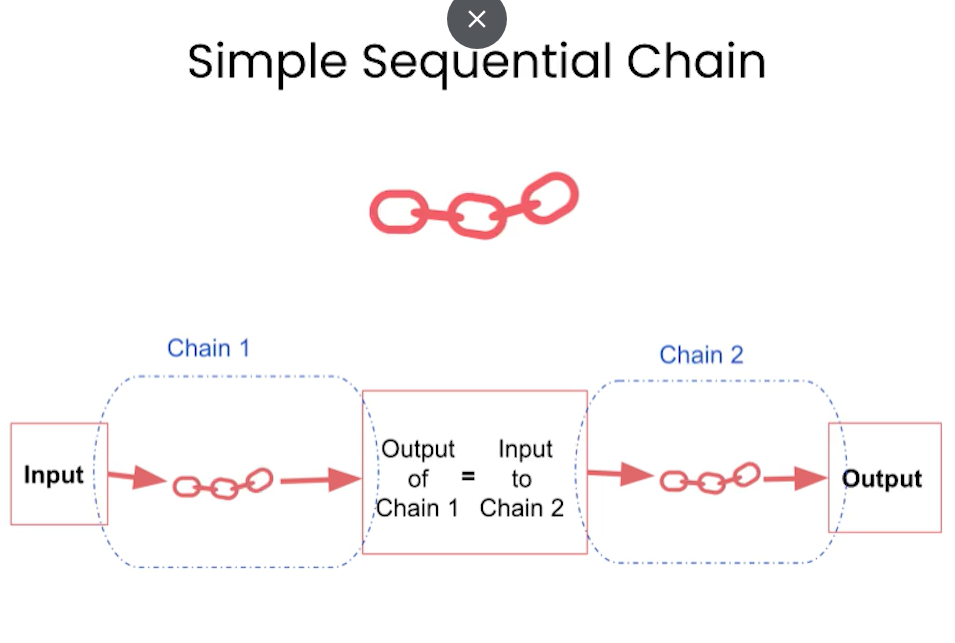

In [12]:
from langchain.chains import SimpleSequentialChain

In [13]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [14]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [15]:
overall_simple_chain = SimpleSequentialChain(
    chains=[chain_one, chain_two],
    verbose=True,
    )

In [16]:
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
RoyalRest
RoyalRest is a luxury mattress brand offering supreme comfort and support for a truly regal sleeping experience.

> Finished chain.


'RoyalRest is a luxury mattress brand offering supreme comfort and support for a truly regal sleeping experience.'

## SequentialChain

Avec cette librairie, contrairement à la librairie SimpleSequentialChain, il n'y a pas continuité / cheminement des prompts proposés (une ou plusieurs entrées / une ou plusieurs sorties)

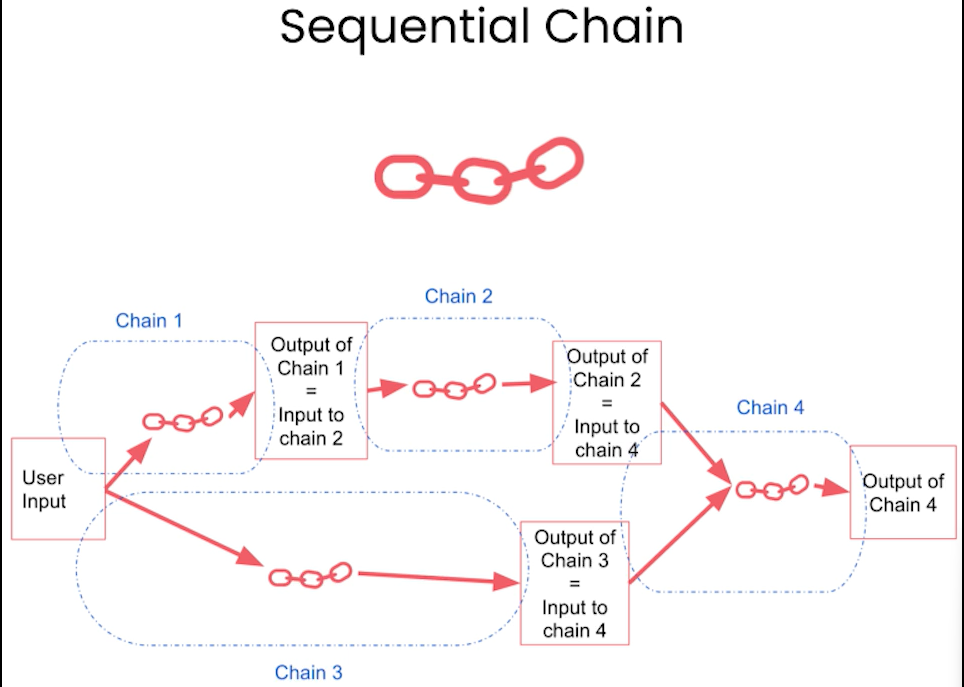

In [17]:
from langchain.chains import SequentialChain

In [19]:
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1: translate to french
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to French:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= French_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="French_Review"
                    )


In [20]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{French_Review}"
)
# chain 2: input= French_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt, 
                     output_key="summary"
                    )


In [21]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )


In [22]:

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )


In [23]:
# overall_chain: input= Review 
# and output= French_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"], # Entrée
    output_variables=["French_Review", "summary","followup_message"], # Sorties
    verbose=True
)

In [24]:
review = df.Review[5]
overall_chain(review)



> Entering new SequentialChain chain...

> Finished chain.


{'Review': "Je trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'French_Review': "I find the taste mediocre. The foam doesn't hold, it's strange. I buy the same ones in stores and the taste is much better...\nOld batch or counterfeit!? \n\nJe trouve le goût médiocre. La mousse ne tient pas, c'est bizarre. J'achète les mêmes dans le commerce et le goût est bien meilleur...\nVieux lot ou contrefaçon !?",
 'summary': "The reviewer finds the taste mediocre and the foam doesn't hold, questioning if it's an old batch or counterfeit.",
 'followup_message': "Réponse: Nous vous remercions d'avoir partagé votre avis sur notre produit. Nous sommes désolés d'apprendre que vous avez trouvé le goût moyen et que la mousse ne tient pas. Nous tenons à vous assurer que nos produits sont fabriqués avec les meilleurs ingrédients et que chaque lot est soigneusement contrôlé pour garantir une q

## Router Chain

Avec cette librairie, on a deux situations 
- Soit la réponse est présentée selon le prompt préalablement établi
- Soit aucun prompt n'est en "lien" avec la question posée

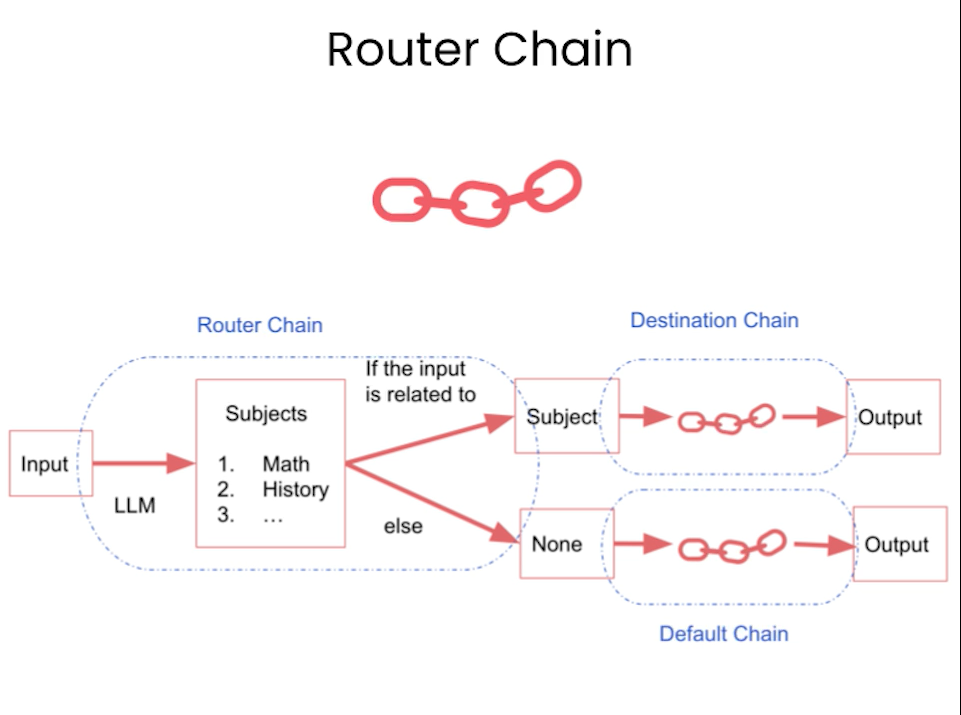

In [25]:
# Configuration des prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""


math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""


computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [26]:
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    }
]

In [27]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [28]:
llm = ChatOpenAI(temperature=0, model=llm_model)

In [29]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [30]:
default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [31]:
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is not\
well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input \
if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

In [32]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [33]:
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain, verbose=True
                        )

In [34]:
chain.run("What is black body radiation?")



> Entering new MultiPromptChain chain...
physics: {'input': 'What is black body radiation?'}
> Finished chain.


'Black body radiation refers to the electromagnetic radiation emitted by an object that absorbs all incident radiation and reflects or transmits none. It is called "black body" because it absorbs all wavelengths of light, appearing black at room temperature. \n\nAccording to Planck\'s law, black body radiation is characterized by a continuous spectrum of wavelengths and intensities, which depend on the temperature of the object. As the temperature increases, the peak intensity of the radiation shifts to shorter wavelengths, resulting in a change in color from red to orange, yellow, white, and eventually blue at very high temperatures.\n\nBlack body radiation is a fundamental concept in physics and has significant applications in various fields, including astrophysics, thermodynamics, and quantum mechanics. It played a crucial role in the development of quantum theory and understanding the behavior of light and matter.'

In [35]:
chain.run("what is 2 + 2")



> Entering new MultiPromptChain chain...
math: {'input': 'what is 2 + 2'}
> Finished chain.


'Thank you for your kind words! As a mathematician, I am happy to help with any math questions, no matter how simple or complex they may be.\n\nThe question you\'ve asked is a basic addition problem: "What is 2 + 2?" To solve this, we can simply add the two numbers together:\n\n2 + 2 = 4\n\nTherefore, the answer to the question "What is 2 + 2?" is 4.'

In [36]:
chain.run("Why does every cell in our body contain DNA?")



> Entering new MultiPromptChain chain...
None: {'input': 'Why does every cell in our body contain DNA?'}
> Finished chain.


'Every cell in our body contains DNA because DNA is the genetic material that carries the instructions for the development, functioning, and reproduction of all living organisms. DNA contains the information necessary for the synthesis of proteins, which are essential for the structure and function of cells. It serves as a blueprint for the production of specific proteins that determine the characteristics and traits of an organism. Additionally, DNA is responsible for the transmission of genetic information from one generation to the next during reproduction. Therefore, every cell in our body contains DNA to ensure the proper functioning and continuity of life.'